# keras 入门

几个月前，我在Fast Forward实验室开始了一项新的研究。我的新同事们已经用卷积神经网络完成了一个图像识别项目，他们开始启动一个新项目：使用递归神经网络(RNN)做文本摘要。我之前没折腾过神经网络，所以我必须快点学习。

尽管近来深度学习令人兴奋，但神经网络在非专业人士的眼里名声并不佳，这似乎是一种计算密集型的训练任务，难以解释，难以创建

这也是我自己确切的感受，虽然它不好解释，而且依然会希望使用强大的硬件去训练和运行大型神经网络，然而构建和探索神经网络最近已经变得简单许多

原因是高层次（译者注：抽象，封装了许多底层细节）的神经网络库允许开发者快速构建神经网络模型，而无需担心浮点运算的数值细节、张量代数和GPU编程


今天我们将走进[Keras](https://github.com/fchollet/keras)。Keras是一个高层次的神经网络库，包含了许多东西，封装了与scikit-learn相似的api，后端采用Theano或是TensorFlow

出于Keras与scikit-learn的相似性，并且神经网络的设计与测试都是对所有人开发的以及对所有人开放的，我将给你一个引导教程：通过与scikit-learn的比较来使用Keras

Scikit-learn是python社区里最流行、功能完备而经典的机器学习库。在它的诸多优点中，我最喜欢它的简单、连贯而一致的API，它们围绕Estimator对象构建。这些API很好地描述了机器学习的工作流，这些工作流为大多工程师所熟悉，并且它们在这个库中始终保持一致

接下来，让我们开始导入我们需要的库：scikit-learn, Keras and 和其他的绘图工具（译者注：演示代码运行在ipython notebook/jupyter notebook中）

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential # 我目前的版本是Keras==1.0.7
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
# Using Theano backend.

/Users/wwj/env/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Using Theano backend.


# Iris data(鸢尾花卉数据集)
著名的[iris dataset](https://zh.wikipedia.org/zh/%E5%AE%89%E5%BE%B7%E6%A3%AE%E9%B8%A2%E5%B0%BE%E8%8A%B1%E5%8D%89%E6%95%B0%E6%8D%AE%E9%9B%86) （由Ronald Fisher发布于1936年）是一个用于演示机器学习框架API的好方法。在某种意义上，它是机器学习世界的`Hello world`

数据集很简单，有可能在其上获得一个得准确度很高的简单分类。使用神经网络去处理这个问题，属于杀鸡用牛刀。可是很好玩！我们的目的是探索给这些数据做分类所需的代码，而不是模型的设计和选择的细节

iris 数据集内置于许多机器学习库中，我喜欢从[seaborn](https://github.com/mwaskom/seaborn)中获取它，（在seaborn中）它作为一个带有标记的dataframe，很容易做可视化。反正我们也要用seaborn，因此在最初的5个例子里让我们从中加载

In [2]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


![](https://raw.githubusercontent.com/fastforwardlabs/keras-hello-world/f304c056c53b2eaa3402d49702a54a7f8a0368a0/Iris_sanguinea.JPG)

每个例子中(诸如 花)，有五个字段，其中四个是花的尺寸(cm)，第五个是鸢尾花的品种（类别）。有三个品种：setosa, verscicolor 和 virginica。我们的工作是构建一个分类器，输入两个花瓣和两个萼片的测量数据，分类器能预测它的品种。我们在正式开始构建模型之前，先来做个可视化（先做可视化通常是好主意）：

/Users/wwj/env/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


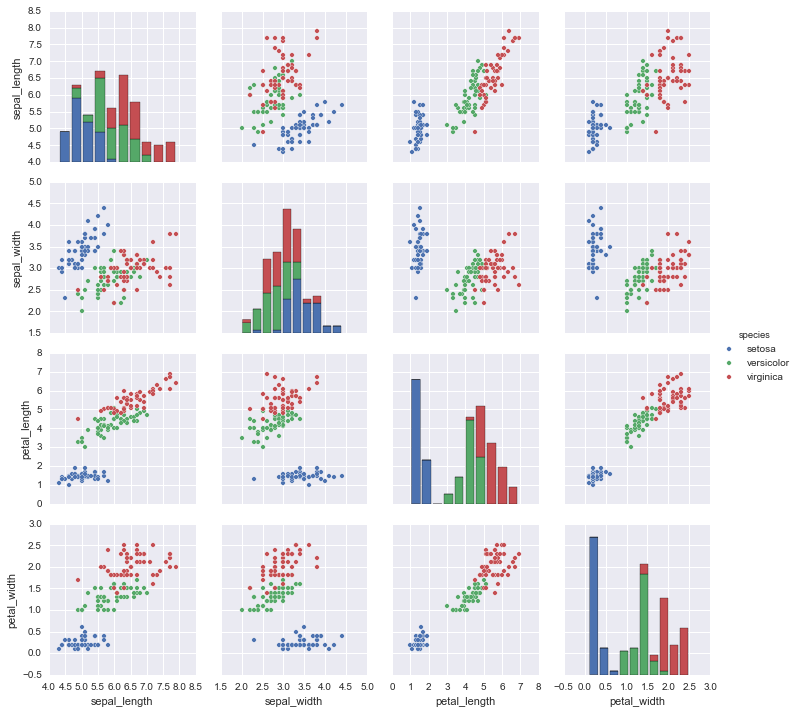

In [3]:
sns.pairplot(iris, hue='species');

## 为训练和测试切分/转化数据
首先我们要从iris dataframe中取出数据. 我们将花瓣和萼片数据存在数组X里(特征)，而将分类标签存在对应的数组y里（目标）


In [4]:
X = iris.values[:, :4]
y = iris.values[:, 4]

在标准的监督学习中，我们会训练数据集中的一些数据，并用余下数据测试我们模型的表现。尽管手动操作也很简单，但这些工作已被抽象为scikit-learn中的`train_test_split()`方法


In [5]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.5, random_state=0)


# 训练一个scikit-learn分类器
我们将训练一个逻辑回归（或称逻辑斯蒂回归）(logisitic regression)分类器。使用scikit-learn内置的hyper-paramter交叉验证，只需一行代码搞定。和scikit-learn的Estimator对象一样，LogisticRegressionCV分类器有一个`.fit()`方法，该方法将调整模型参数，使其与训练数据契合。该方法就是我们的唯一需要的，我们只需：


In [6]:
lr = LogisticRegressionCV()
lr.fit(train_X, train_y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

## 获取分类器分类准确率
现在我们可以用测试集测量训练好的分类器的分类准确率：

In [7]:
print("Accuracy = {:.2f}".format(lr.score(test_X, test_y)))

Accuracy = 0.83


# 使用Keras来做这些（和上边相似）
Keras是一个高级的神经网络库，由Google的 François Chollet创建。第一次提交到github是去年的3月27号，它才一岁

如我们所见，用scikit-learn构建分类器是十分容易的：

*  用一行代码来实例化分类器
*  用一行代码来训练它
*  用一行代码来测量分类器准确性

在Keras中创建一个分类器只比上述过程复杂一点点。数据需要做一点调整，另外在我们将神经网络实例化为分类器之前，需要花一些功夫先定义神经网络。其他方面和scikit-learn十分接近

首先需要调整这些数据：scikit-learn的分类器接受字符串标签，例如："setosa"，而keras的标签必须是`one-hot-encoded`，这意味着我们需要将数据：


```
setosa
versicolor
setosa
virginica
...
```

变为如下形式：

```
setosa versicolor virginica
     1          0         0
     0          1         0
     1          0         0
     0          0         1
```

有许多方法能实现，如果你熟悉pandas，可以使用`pandas.get_dummies()`，`one-hot-encoding`内置于scikit-learn。我们只用到Keras的一些工具和部分numpy知识


In [13]:
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

train_y_ohe = one_hot_encode_object_array(train_y)
test_y_ohe = one_hot_encode_object_array(test_y)

## 构建神经网络模型
这个例子中，除了需要转化数据，使用Keras（与scikit-learn）最显著而重要的区别是：在你实例化之前必须确定模型的结构

在scikit-learn中，模型是现成的。然而Keras是一个神经网络库。因此，尽管数据中的 特征/类别 的数量给出了约束，你却可以决定模型的其他方面: 层数、每层的规模、层与层直接的连接性质 等等。（如果你目前还没什么体会，Keras是个绝佳的实验场所）

这种自由的代价是，实例化最小分类器涉及的工作比scikit-learn所需的一行代码多一点。

在我们的例子中，我们将创建一个简单的网络。数据为我们做了两个选择。我们有四个特征值和3个目标分类，因此输入层必须有4个单元（神经元），而输出层必须有3个单元。我们只需要定义隐含层，这个项目中我们将拥有一个隐含层，赋予它16个单元。从GPU的角度来看，16是一个整数！当你用神经网络时，会看到数字2经常拥有特权。

我们将使用最常规的方法来定义我们的模型：定义为一个顺序叠层，另一种选择是定义为一个计算图(computational graph)。但我们在这里使用`Sequential()`. （即前者）


In [8]:
model = Sequential() # 顺序模型 参考：http://keras-cn.readthedocs.io/en/latest/

接下来的两行代码定义输入层的规模（input_shape=(4,)）, 以及隐含层的规模和激活函数


In [9]:
model.add(Dense(16, input_shape=(4,)))  # Dense就是常用的全连接层（dense是稠密的意思) 参考：http://keras-cn.readthedocs.io/en/latest/layers/core_layer/
model.add(Activation('sigmoid')) # 激活函数，参考 http://keras-cn.readthedocs.io/en/latest/other/activations/


接下来定义输出层的规模和激活函数：


In [10]:
model.add(Dense(3))
model.add(Activation('softmax'))

最后我们指定优化策略和损失函数。我们同时计算准确率


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

## 使用神级网络分类器
现在我们已经定义了模型的结构且编译好了，我们有了一个api和scikit-learn基本一样的对象。它也有`.fit()`和`.predict()`方法. 接下来将模型和数据二者契合即可！ 

神级网络的训练通常包含一个称为`minibatching`(迷你批处理) 概念,意思是向网络展示数据的一个子集，调整权值，然后向网络展示数据的另一子集. 神经网络学完所有的数据，被称为`epoch`.调整`minibatch/epoch`策略是一个专门的问题. 在本例中我们我们只使用一个minibatch, 这使得它能很好地使用随机梯度下降法.例如，神经网络每次扫过一条鲜花样本数据，权重相应进行调节

下边式子是否包含`verbose=0`无关紧要. 如果你想调整`minibatch/epoch`策略，每次需要重新运行前头的`model.compile()`来重置模型权重


In [14]:
model.fit(train_X, train_y_ohe, nb_epoch=100, batch_size=1, verbose=0);


一般来说，对于编译好的keras模型和scikit-learn分类器，API的唯一不同是:scikit-learn的`.score()`方法对应Keras的`.evaluate()`

当我们编译模型时，`evaluate()` 返回损失函数和其他我们需要的指标. 在我们的例子中,我们需要`accuracy`, 可以将其类比于用scikit-learn `LogisticRegressionCV` 分类器的`score()`方法返回的准确率（accuracy）


In [15]:
loss, accuracy = model.evaluate(test_X, test_y_ohe, verbose=0)
print("Accuracy = {:.2f}".format(accuracy))

Accuracy = 0.99


如你所见，神经网络模型的测试准确率比简单逻辑回归分类器的要好。

这是令人欣慰的，但并不使人惊讶.甚至是很简单的神经网络，相较逻辑回归而言，也具有更高的灵活性去学习更为复杂的分类问题，所以它当然比逻辑回归做得更好

而且它也揭露了神经网络的风险之一：过拟合。此前，我们细心地进行选出测试集，并在其上做检验,但测试集太小了，99%的正确率似乎非常高,如果之后有一些过度拟合,我不会为此感到惊讶.你可以添加`dropout`（内置于Keras）,这相当于`LogisticRegression`分类器使用的的正则化（译者注：推荐阅读李航《统计学习方法》）。

我们到此为止，神级网络已经对这个问题矫枉过正了，对准确率的处理不是我想演示的。这篇文章想做的演示是使用一个内置电池的高级源码库，我们只需要写少量代码就能构建、训练并且使用一个神经网络模型，而不是一个传统的模型


## 下一步
我们构建一个非常简单的前馈神经网络。为了进一步探索，我们可以加载手写数字数据库([MNIST database of handwritten digits](https://keras.io/datasets/)),试试你能否击败一个标准的scikit-learn分类器. 与Iris数据集不同, 这个解决方方案中，神级网络的能力和与之相应的复杂度是合理的. 你可以自己试试，如果中途卡壳，可以看看[notebook](https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb)

找到你最喜欢的语言和库的教程是容易的，如果你有兴趣多了解一些概念和数学背景，试试以下资源：

*  Michael Nielsen的在线书籍[Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/)(特别是1，2，3章)
*  吴恩达在Coursera上的课程：[机器学习](https://www.coursera.org/learn/machine-learning)(4-5周),
*  [Deep Learning](http://www.nature.com/nature/journal/v521/n7553/abs/nature14539.html) by Yan Le Cun
*  Chris Olah的[精彩文章](http://colah.github.io/), 特别是[back propagation](http://colah.github.io/posts/2015-08-Backprop/)和[recurrent neural networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

说到回归神经网络，Keras也有让您建立模型的`layers`：

*  卷积层，解决机器视觉问题最先进的方案
*  递归层,特别适合于为语言和其它序列数据建模。

事实上，神经网络的强大之处来自它的可组合性。使用类似Keras这类高级库,只需一会儿就能构建一个不同的神经网络。构建模型和搭乐高积木差不多。很好玩哒！



# 原文
*  ["Hello world" in keras](https://github.com/fastforwardlabs/keras-hello-world/blob/master/kerashelloworld.ipynb)
